In [1]:
# https://github.com/chasewalker26/Magnitude-Aligned-Scoring

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os 
from skimage.transform import resize as skimage_resize

os.sys.path.append(os.path.dirname(os.path.abspath('..')))

# attribution and calibration methods
from captum.attr import IntegratedGradients, LayerGradCam, GuidedBackprop, GuidedGradCam
from util import model_utils
from util.attribution_methods import saliencyMethods as attr
from util.attribution_methods import GIGBuilder as GIG_Builder
from util.attribution_methods import AGI as AGI
from util.test_methods import MASTestFunctions as MAS
from util.test_methods import RISETestFunctions as RISE
from util.test_methods import PICTestFunctions as PIC
from util.modified_models import resnet
from util.visualization import attr_to_subplot

# modify this if you don't have a GPU
device = "cuda:0"

model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to(device)

# set up new AGI model
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = AGI.Normalize(mean, std)
AGI_model = nn.Sequential(norm_layer, model).to(device)

# modified model for GC and GGC captum functions
modified_model = resnet.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
modified_model = modified_model.eval()
modified_model.to(device)

img_hw = 224

# transform data into format needed for model model model expects 224x224 3-color image
transform = transforms.Compose([
     transforms.Resize((img_hw, img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

resize = transforms.Resize((img_hw, img_hw))
crop = transforms.CenterCrop(img_hw)

open an image and perform transformations

75.93096494674683 submarine


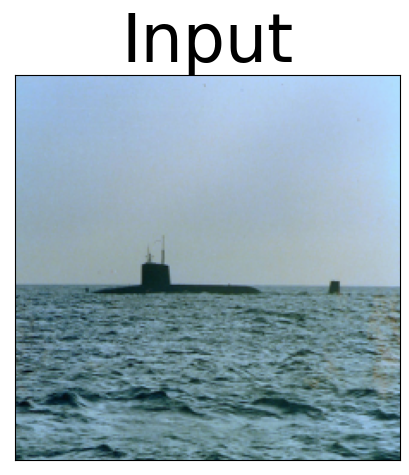

In [2]:
# load an image from the example folder
image_path = "images/submarine.JPEG"
# image_path = "images/birds.JPEG"
# image_path = "images/warplane.JPEG"

img = Image.open(image_path)
trans_img = transform(img)
img_tensor = transform_normalize(trans_img)
input_tensor = torch.unsqueeze(img_tensor, 0)

target_class = model_utils.getClass(input_tensor, model, device)
# open the class list so the detected class string can be returned for printing
with open('util/class_maps/ImageNet/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
name = classes[target_class]
print(model_utils.getPrediction(input_tensor, model, device, target_class)[0] * 100, name)

# Show the image
plt.rcParams.update({'font.size': 40})
fig, axs = plt.subplots(1, 1, figsize = (5, 5))
attr_to_subplot(trans_img, "Input", axs, original_image=True)
plt.show()
plt.close(fig)

Generate all of the attributions

In [3]:
# Attributions
########  IG  ########
integrated_gradients = IntegratedGradients(model)
ig = integrated_gradients.attribute(input_tensor.to(device), 0, target = target_class, n_steps = 50, internal_batch_size=25)
ig = np.transpose(ig.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  LIG  ########
lig  = attr.IG(input_tensor, model, 50, 25, .9, 0, device, target_class)
lig = np.transpose(lig.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  GC  ########
layer = model.layer4
layer_gc = LayerGradCam(model, layer)
input_tensor.requires_grad = True
gc = layer_gc.attribute(input_tensor.to(device), target_class, relu_attributions=True)
gc = skimage_resize(gc.squeeze().cpu().detach().numpy(), (224, 224), preserve_range=True)
gc = torch.tensor(gc).reshape((1, 224, 224)) * torch.ones((3, 224, 224))
input_tensor.requires_grad = False
gc = np.transpose(gc.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  GGC  ########
guided_gc = GuidedGradCam(modified_model, modified_model.layer4)
input_tensor.requires_grad = True
ggc = guided_gc.attribute(input_tensor.to(device), target_class)
input_tensor.requires_grad = False
ggc = np.transpose(ggc.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  GBP  ########
guided_bp = GuidedBackprop(modified_model)
input_tensor.requires_grad = True
gbp = guided_bp.attribute(input_tensor.to(device), target = target_class)
input_tensor.requires_grad = False
gbp = np.transpose(gbp.squeeze().detach().cpu().numpy(), (1, 2, 0))

########  GIG  ########
call_model_args = {'class_idx_str': target_class.item()}
guided_ig = GIG_Builder.GuidedIG()
baseline = torch.zeros_like(input_tensor)
gig = guided_ig.GetMask(input_tensor, model, device, GIG_Builder.call_model_function, call_model_args, x_baseline = baseline, x_steps = 50, max_dist = 1.0, fraction = 0.5)
gig = np.transpose(gig.squeeze().detach().cpu().numpy(), (1, 2, 0))
    
########  AGI  ########
def threshold(saliency_map, lowerbound = 10, upperbound = 99, img_hw = 224):
    hm = saliency_map
    hm = np.mean(hm, axis=0)
    l = np.percentile(hm, lowerbound)
    u = np.percentile(hm, upperbound)

    hm[hm < l] = l
    hm[hm > u] = u

    hm = (hm - l)/(u - l)

    saliency_map = np.reshape(hm, (img_hw, img_hw, 1))
    
    return saliency_map

epsilon = 0.05
max_iter = 20
topk = 1
# define the ids of the selected adversarial class
selected_ids = range(0, 999, int(1000 / topk)) 
agi_img = AGI.LoadImage(image_path, resize, crop)
agi_img = agi_img.astype(np.float32) 
# Run test
example = AGI.test(AGI_model, device, agi_img, epsilon, topk, selected_ids, max_iter)
AGI_map = example[2]
agi = np.transpose(AGI_map, (1, 2, 0))

/home/chasewalker/.local/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


Visualize the attributions

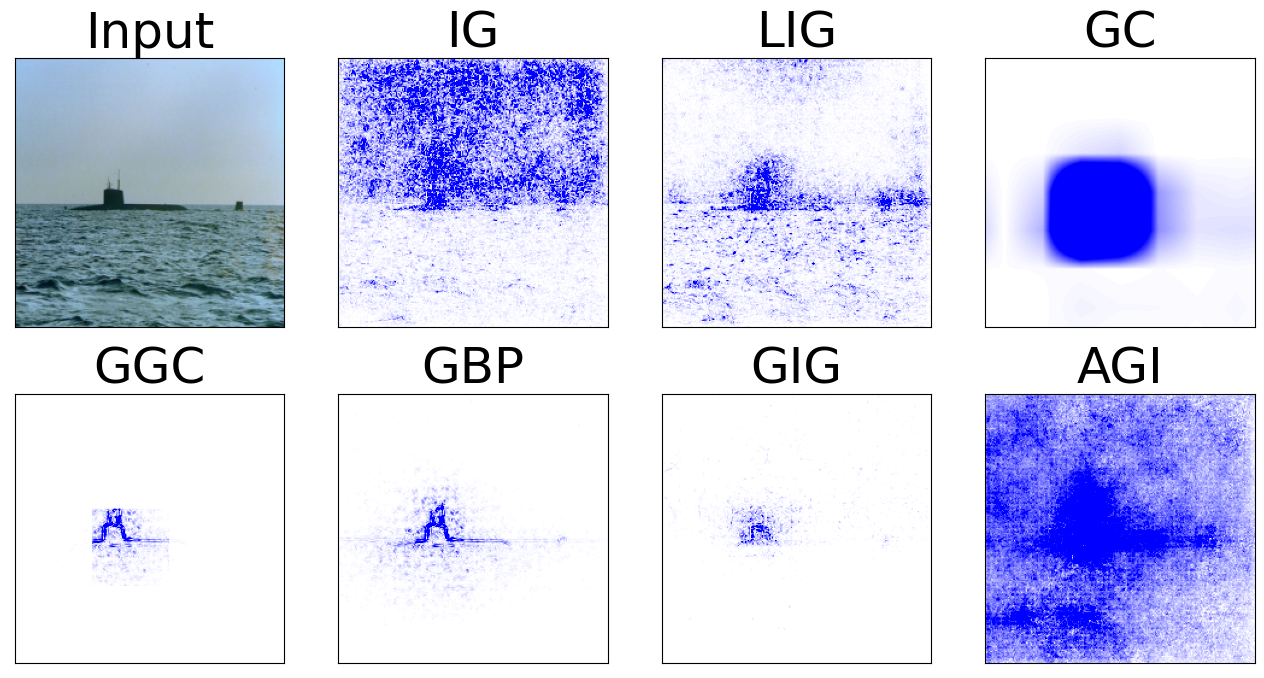

In [4]:
# Display all attributions and input
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(2, 4, figsize = (16, 8))

norm = "absolute"

attr_to_subplot(trans_img, "Input", axs[0, 0], original_image = True)
attr_to_subplot(ig, "IG", axs[0, 1], norm = norm)
attr_to_subplot(lig, "LIG", axs[0, 2], norm = norm)
attr_to_subplot(gc, "GC", axs[0, 3], norm = norm)
attr_to_subplot(ggc, "GGC", axs[1, 0], norm = norm)
attr_to_subplot(gbp, "GBP", axs[1, 1], norm = norm)
attr_to_subplot(gig, "GIG", axs[1, 2], norm = norm)
attr_to_subplot(agi, "AGI", axs[1, 3], norm = norm)

plt.show()
plt.close(fig)

Setup the quality metric classes and scoring functions

In [5]:
# Quality metrics - each one returns the AUC score [0, 1].

####### MAS #######
# To use the MAS test, these wrappers must be defined:

# Blurring kernel for MAS insertion as well as RISE inserion.
klen = 11
ksig = 11
kern = RISE.gkern(klen, ksig)
blur = lambda x: nn.functional.conv2d(x, kern, padding = klen // 2)

# Build the insertion and deletion classes,
# Inputs are: model, total image area, test method, number of pixels modified per perturbation (default sqrt(img_hw**2)), and the baseline 
MAS_insertion = MAS.MASMetric(model, img_hw**2, 'ins', img_hw, substrate_fn = blur)
MAS_deletion = MAS.MASMetric(model, img_hw**2, 'del', img_hw, substrate_fn = torch.zeros_like)

# Build the wrapper functions.
# Inside of each wrapper function, the saliency map is transformed from [224, 224, 3] to [224, 224].
# This is done via the standard process of summing across channels and taking the absolute value of all pixels.
def MAS_ins_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    n_steps, corrected_score, alignment_penalty, density_response, model_response = MAS_insertion.single_run(img_tensor, saliency_map_test, device)
    return MAS.auc(corrected_score)

def MAS_del_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    n_steps, corrected_score, alignment_penalty, density_response, model_response = MAS_deletion.single_run(img_tensor, saliency_map_test, device)
    return MAS.auc(corrected_score)



####### RISE #######
# RISE tests operate in the same way as the MAS tests
RISE_insertion = RISE.CausalMetric(model, img_hw**2, 'ins', img_hw, substrate_fn = blur)
RISE_deletion = RISE.CausalMetric(model, img_hw**2, 'del', img_hw, substrate_fn = torch.zeros_like)

def RISE_ins_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    n_steps, ins = RISE_insertion.single_run(img_tensor, saliency_map_test, device)
    return RISE.auc(ins)

def RISE_del_test(img_tensor, saliency_map):
    saliency_map_test = np.abs(np.sum(saliency_map, axis = 2))
    n_steps, delete = RISE_deletion.single_run(img_tensor, saliency_map_test, device)
    return RISE.auc(delete)



######## PIC tests #######
random_mask = PIC.generate_random_mask(img_hw, img_hw, .01)
saliency_thresholds = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.10, 0.13, 0.21, 0.34, 0.5, 0.75]

def SIC_test(img_test, saliency_map):   
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    sic_score = PIC.compute_pic_metric(img_test, saliency_map, random_mask, saliency_thresholds, 0, model, device, normalization=transform_normalize)
    return sic_score.auc

def AIC_test(img_test, saliency_map):   
    saliency_map = np.abs(np.sum(saliency_map, axis = 2))
    aic_score = PIC.compute_pic_metric(img_test, saliency_map, random_mask, saliency_thresholds, 1, model, device, normalization=transform_normalize)
    return aic_score.auc

Score the attributions

In [6]:
# available attributions: ig, lig, gc, ggc, gbp, gig, agi
# select the one you want to test with MAS, RISE, and PIC
selected_attribution = gc

Score with MAS

In [7]:
# MAS scoring
# Inputs: normalized tensor input image [1, 3, 224, 224] and the attribution [224, 224, 3]
MAS_ins_score = MAS_ins_test(input_tensor, selected_attribution)
MAS_del_score = MAS_del_test(input_tensor, selected_attribution)
MAS_diff_score = MAS_ins_score - MAS_del_score

print("MAS Ins: " + str(MAS_ins_score))
print("MAS Del: " + str(MAS_del_score))
print("MAS Difference: " + str(MAS_diff_score))

MAS Ins: 0.9207455861720862
MAS Del: 0.0791213102076468
MAS Difference: 0.8416242759644394


Score with RISE

In [8]:
# RISE scoring
# The RISE function takes the same inputs as MAS 
RISE_ins_score = RISE_ins_test(input_tensor, selected_attribution)
RISE_del_score = RISE_del_test(input_tensor, selected_attribution)
RISE_diff_score = RISE_ins_score - RISE_del_score

print("RISE Ins: " + str(RISE_ins_score))
print("RISE Del: " + str(RISE_del_score))
print("RISE Difference: " + str(RISE_diff_score))

RISE Ins: 0.7500514935475492
RISE Del: 0.03249059140333494
RISE Difference: 0.7175609021442142


Score with PIC

In [9]:
# PIC scoring
# Inputs: unnormalized tensor input image [224, 224, 3] and the attribution [224, 224, 3]
PIC_img = np.transpose(trans_img.numpy(), (1, 2, 0))
SIC_score = SIC_test(PIC_img, selected_attribution)
AIC_score = AIC_test(PIC_img, selected_attribution)
print("SIC: " + str(SIC_score))
print("AIC: " + str(AIC_score))

SIC: 0.9491423390193359
AIC: 0.951925398902184
